## No Text Prep + TF-IDF + NB, SVM, LR, MLP 

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('airy_sample_data.csv')

In [3]:
data_df = pd.DataFrame(data)
data_df = data_df.drop(columns=['review_id'])
data_df = data_df.drop(columns=['review_source'])
data_df = data_df.drop(columns=['review_score'])
data_df.head()

,review_text,category
0,"Mantap, lumayan bersih, ada kulkasnya cuma kul...",NaN
1,"suasana tenang, cocok untuk istirahat",NaN
2,"kamarnya bersih, rapi, nyaman. seneng banget n...",NaN
3,goooooooooddddd,NaN
4,nyaman bersih,NaN


In [4]:
data_df.isnull().any()

review_text    True
category       True
dtype: bool

In [5]:
data_df = data_df.dropna()
data_df.head()

,review_text,category
13,"Lazy front office girl, no one was there to he...",service_front_office
15,suka banget tapi sayang kemarin dapat kamar ya...,kebersihan_inroom_P1
16,suka banget tapi sayang kemarin dapat kamar ya...,bau_P1
19,kamar saya tidak dapat sabun dan cemilan airy ☹,sunrise_meal_P1
20,kamar saya tidak dapat sabun dan cemilan airy ☹,perlengkapan_mandi_P1


## Remove NaN

In [6]:
X_train = list(data_df.dropna()['review_text'])
y_train = list(data_df.dropna()['category'])

## Aspect Categories

In [7]:
category = list(set(y_train))
print(len(category))
print(category)

30
['air_panas_P1', 'rusak', 'airy_internal', 'kebersihan', 'bising', 'lokasi', 'sunrise_meal_P1', 'fasilitas', 'fisik_bangunan', 'handuk_P1', 'wifi_P1', 'bau_P1', 'kebersihan_inroom_P1', 'service_security', 'kebersihan_non_inroom', 'service_front_office', 'fasilitas_inroom', 'service', 'tidak_sesuai_pesanan', 'fasilitas_non_inroom', 'perlengkapan_mandi_P1', 'air_minum_P1', 'linen_P1', 'tv_P1', 'ac_P1', 'breakfast', 'serangga', 'overall', 'marketing_false', 'service_house_keeping']


In [8]:
from collections import Counter
c = Counter(y_train)
counts = []
for i in category:
    counts.append((i, c[i]))
                  
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_review'])
df_stats

,category,number_of_review
0,air_panas_P1,11
1,rusak,8
2,airy_internal,3
3,kebersihan,18
4,bising,5
5,lokasi,4
6,sunrise_meal_P1,12
7,fasilitas,13
8,fisik_bangunan,12
9,handuk_P1,12


Text(0.5,0,'category')

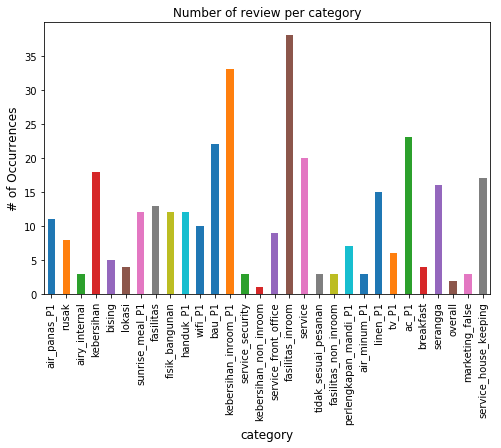

In [9]:
df_stats.plot(x='category', y='number_of_review', kind='bar', legend=False, grid=False, figsize=(8, 5))
plt.title("Number of review per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## Transforming Dataset to One Hot

In [10]:
def get_all_label(x_train, y_train):
    y_train_set = []
    sent = x_train[0]
    X_train_set = [sent]
    labels = []
    for i in range (len(x_train)):
        if sent != x_train[i]:
            if (len(labels)>0):
                y_train_set.append(labels)
            sent = x_train[i]
            X_train_set.append(sent)
            labels = []
        labels.append(y_train[i])
    return X_train_set, y_train_set

In [11]:
X_train_set, y_train_set = get_all_label(X_train, y_train)

In [12]:
data_train = list(zip(X_train_set, y_train_set))

In [13]:
df_train = pd.DataFrame(data_train, columns=['review', 'labels'])
df_train.head()

,review,labels
0,"Lazy front office girl, no one was there to he...",[service_front_office]
1,suka banget tapi sayang kemarin dapat kamar ya...,"[kebersihan_inroom_P1, bau_P1]"
2,kamar saya tidak dapat sabun dan cemilan airy ☹,"[sunrise_meal_P1, perlengkapan_mandi_P1]"
3,di tengah pusat keramaian... staf hotel yang r...,[fasilitas]
4,closet nya rusak kamar mandi tidak bersih lema...,"[rusak, serangga, kebersihan_inroom_P1]"


In [14]:
df_train.to_csv('data_multilabels.csv', sep=',')

In [15]:
mlb = MultiLabelBinarizer()
y = df_train.labels
y = mlb.fit_transform(y).tolist()
mlb.classes_

array(['ac_P1', 'air_minum_P1', 'air_panas_P1', 'airy_internal', 'bau_P1',
       'bising', 'breakfast', 'fasilitas', 'fasilitas_inroom',
       'fasilitas_non_inroom', 'fisik_bangunan', 'handuk_P1',
       'kebersihan', 'kebersihan_inroom_P1', 'kebersihan_non_inroom',
       'linen_P1', 'lokasi', 'marketing_false', 'overall',
       'perlengkapan_mandi_P1', 'rusak', 'serangga', 'service',
       'service_front_office', 'service_house_keeping',
       'service_security', 'sunrise_meal_P1', 'tidak_sesuai_pesanan',
       'tv_P1', 'wifi_P1'], dtype=object)

In [16]:
df_y = pd.DataFrame(y, columns=mlb.classes_)
df_train = df_train.join(df_y)
df_train = df_train.drop(columns=['labels'])
df_train

,review,ac_P1,air_minum_P1,air_panas_P1,airy_internal,bau_P1,bising,breakfast,fasilitas,fasilitas_inroom,...,rusak,serangga,service,service_front_office,service_house_keeping,service_security,sunrise_meal_P1,tidak_sesuai_pesanan,tv_P1,wifi_P1
0,"Lazy front office girl, no one was there to he...",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,suka banget tapi sayang kemarin dapat kamar ya...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,kamar saya tidak dapat sabun dan cemilan airy ☹,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,di tengah pusat keramaian... staf hotel yang r...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,closet nya rusak kamar mandi tidak bersih lema...,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
5,"staf kurang responsif, hanya sekedar minta air...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,Pelayanan hotel tidak memauaskan. Tidak ada sa...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,"lampu kamar remang2, wc tidak memadai tidak ad...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,Untuk ditingkatkan kembali kebersihannya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,air mati,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_train.to_csv('data_multilabels_onehot.csv', sep=',')

## Experiment

In [18]:
train, test = train_test_split(df_train, random_state=42, test_size=0.2, shuffle=True)

In [19]:
X_train = list(train.review)
X_test = list(test.review)

## Naive Bayes

In [24]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
sum_f1 = 0
for c in category:
    print('... Processing {}'.format(c))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[c])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    f1 = f1_score(test[c], prediction)
    sum_f1 += f1
    #print('Test F1-Measure is {}'.format(f1))

... Processing air_panas_P1
... Processing rusak
... Processing airy_internal
... Processing kebersihan
... Processing bising
... Processing lokasi
... Processing sunrise_meal_P1
... Processing fasilitas
... Processing fisik_bangunan
... Processing handuk_P1
... Processing wifi_P1
... Processing bau_P1
... Processing kebersihan_inroom_P1
... Processing service_security
... Processing kebersihan_non_inroom
... Processing service_front_office
... Processing fasilitas_inroom
... Processing service


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\li

... Processing tidak_sesuai_pesanan
... Processing fasilitas_non_inroom
... Processing perlengkapan_mandi_P1
... Processing air_minum_P1
... Processing linen_P1
... Processing tv_P1
... Processing ac_P1
... Processing breakfast
... Processing serangga
... Processing overall
... Processing marketing_false
... Processing service_house_keeping


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\li

In [25]:
print(sum_f1/len(category))

0.0


## SVM

In [26]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
sum_f1 = 0
#df = pd.DataFrame(X_test, columns=['review'])
for c in mlb.classes_:
    print('... Processing {}'.format(c))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[c])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    #df = df.join(pd.DataFrame(prediction, columns=[c]))
    f1 = f1_score(test[c], prediction)
    sum_f1 += f1
    #print('Test F1-Measure is {}'.format(f1))

... Processing ac_P1
... Processing air_minum_P1
... Processing air_panas_P1
... Processing airy_internal
... Processing bau_P1
... Processing bising
... Processing breakfast
... Processing fasilitas
... Processing fasilitas_inroom
... Processing fasilitas_non_inroom
... Processing fisik_bangunan
... Processing handuk_P1
... Processing kebersihan
... Processing kebersihan_inroom_P1
... Processing kebersihan_non_inroom
... Processing linen_P1
... Processing lokasi
... Processing marketing_false
... Processing overall

C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packag


... Processing perlengkapan_mandi_P1
... Processing rusak
... Processing serangga
... Processing service
... Processing service_front_office
... Processing service_house_keeping
... Processing service_security
... Processing sunrise_meal_P1
... Processing tidak_sesuai_pesanan
... Processing tv_P1
... Processing wifi_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\li

In [27]:
print(sum_f1/len(category))

0.06773448773448773


In [358]:
# df_test = pd.DataFrame(X_test, columns=['review'])
# df_test.join(pd.DataFrame(pred_label, columns = mlb.classes_)).to_csv('data_multilabels_onehot_test.csv', sep=',')

## LR

In [28]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
sum_f1 = 0
for c in category:
    print('... Processing {}'.format(c))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[c])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    f1 = f1_score(test[c], prediction)
    sum_f1 += f1
    #print('Test F1-Measure is {}'.format(f1))

... Processing air_panas_P1
... Processing rusak
... Processing airy_internal
... Processing kebersihan
... Processing bising
... Processing lokasi
... Processing sunrise_meal_P1
... Processing fasilitas
... Processing fisik_bangunan
... Processing handuk_P1
... Processing wifi_P1
... Processing bau_P1
... Processing kebersihan_inroom_P1

C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages


... Processing service_security
... Processing kebersihan_non_inroom
... Processing service_front_office
... Processing fasilitas_inroom
... Processing service
... Processing tidak_sesuai_pesanan
... Processing fasilitas_non_inroom
... Processing perlengkapan_mandi_P1
... Processing air_minum_P1
... Processing linen_P1
... Processing tv_P1
... Processing ac_P1
... Processing breakfast

C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages


... Processing serangga
... Processing overall
... Processing marketing_false
... Processing service_house_keeping


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
print(sum_f1/len(category))

0.007407407407407407


## MLP

In [30]:
MLP_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MLPClassifier(), n_jobs=1)),
            ])
sum_f1 = 0
for c in category:
    print('... Processing {}'.format(c))
    # train the model using X_dtm & y
    MLP_pipeline.fit(X_train, train[c])
    # compute the testing accuracy
    prediction = MLP_pipeline.predict(X_test)
    f1 = f1_score(test[c], prediction)
    sum_f1 += f1
    #print('Test F1-Measure is {}'.format(f1))

... Processing air_panas_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


... Processing rusak


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing airy_internal


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing kebersihan


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing bising


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing lokasi


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing sunrise_meal_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing fasilitas


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing fisik_bangunan


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing handuk_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing wifi_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing bau_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing kebersihan_inroom_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing service_security


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing kebersihan_non_inroom


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing service_front_office


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing fasilitas_inroom


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing service


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing tidak_sesuai_pesanan


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing fasilitas_non_inroom


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing perlengkapan_mandi_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing air_minum_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing linen_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing tv_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing ac_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing breakfast


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing serangga


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing overall


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing marketing_false


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


... Processing service_house_keeping


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
print(sum_f1/len(category))

0.03707070707070707


In [32]:
from sklearn.ensemble import RandomForestClassifier
RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1)),
            ])
sum_f1 = 0
for c in category:
    print('... Processing {}'.format(c))
    # train the model using X_dtm & y
    RF_pipeline.fit(X_train, train[c])
    # compute the testing accuracy
    prediction = RF_pipeline.predict(X_test)
    f1 = f1_score(test[c], prediction)
    sum_f1 += f1

... Processing air_panas_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing rusak
... Processing airy_internal
... Processing kebersihan
... Processing bising


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\

... Processing lokasi
... Processing sunrise_meal_P1
... Processing fasilitas
... Processing fisik_bangunan
... Processing handuk_P1
... Processing wifi_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anac

... Processing bau_P1
... Processing kebersihan_inroom_P1
... Processing service_security
... Processing kebersihan_non_inroom
... Processing service_front_office


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\

... Processing fasilitas_inroom
... Processing service
... Processing tidak_sesuai_pesanan
... Processing fasilitas_non_inroom
... Processing perlengkapan_mandi_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anac

... Processing air_minum_P1
... Processing linen_P1
... Processing tv_P1
... Processing ac_P1
... Processing breakfast
... Processing serangga
... Processing overall
... Processing marketing_false
... Processing service_house_keeping


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Annisa Nurul Azhar\

In [33]:
print(sum_f1/len(category))

0.029629629629629627


## XGBoost

In [34]:
from xgboost import XGBClassifier
XGB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(XGBClassifier(), n_jobs=1)),
            ])
sum_f1 = 0
for c in category:
    print('... Processing {}'.format(c))
    # train the model using X_dtm & y
    XGB_pipeline.fit(X_train, train[c])
    # compute the testing accuracy
    prediction = XGB_pipeline.predict(X_test)
    f1 = f1_score(test[c], prediction)
    sum_f1 += f1

... Processing air_panas_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


... Processing rusak


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing airy_internal


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing kebersihan
... Processing bising


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


... Processing lokasi


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


... Processing sunrise_meal_P1
... Processing fasilitas


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing fisik_bangunan


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing handuk_P1
... Processing wifi_P1
... Processing bau_P1
... Processing kebersihan_inroom_P1
... Processing service_security
... Processing kebersihan_non_inroom
... Processing service_front_office


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing fasilitas_inroom
... Processing service
... Processing tidak_sesuai_pesanan
... Processing fasilitas_non_inroom
... Processing perlengkapan_mandi_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing air_minum_P1


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing linen_P1
... Processing tv_P1
... Processing ac_P1
... Processing breakfast
... Processing serangga


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


... Processing overall
... Processing marketing_false
... Processing service_house_keeping


C:\Users\Annisa Nurul Azhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
print(sum_f1/len(category))

0.21696969696969695
